In [122]:
from itertools import combinations

import pandas as pd
import numpy as np
import os
import datetime
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")


In [123]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_06"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [124]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
import pprint

figure_2 = config.figure2
figure_4 = config.figure4
figure_6 = config.figure6
colors = config.figure_palette

colors

#pprint.pprint(figure_4.model_dump())

FigurePalette(default_bar='black', default_hist='lightgrey', default_dot='dimgray', box_median_props={'linewidth': 2}, cat_palette='colorblind')

In [126]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]

df_cpvt_unique_by_patient = df_cpvt.drop_duplicates(subset="individual_id")

# MUST REMOVE DUPLICATES BECAUSE IT VIOLATES THE
# INDEPENDENCE ASSUMPTION OF STATISTICAL TESTS
df_cpvt_analysis = df_cpvt.drop_duplicates(subset="individual_id", keep=False)

AGE_OF_ONSET_COL = "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1"

In [127]:
print(f"Number of CPVT patients: {len(df_cpvt_unique_by_patient)}")
print(
    f"Number of patients that can be used for analysis: {len(df_cpvt_analysis)}")

Number of CPVT patients: 964
Number of patients that can be used for analysis: 963


In [128]:
from analysis.database import FigureParams
from typing import Literal


def set_figure_size(
        figure_params: FigureParams,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_tick_rotation: int = 0,
):
    plt.xlabel(figure_params.xlabel, fontsize=figure_params.x_label_fontsize)
    plt.ylabel(figure_params.ylabel, fontsize=figure_params.y_label_fontsize)
    plt.title(figure_params.title, fontsize=figure_params.title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha,
               fontsize=figure_params.x_tick_fontsize)
    plt.yticks(fontsize=figure_params.y_tick_fontsize)
    sns.despine()
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

In [129]:
from analysis.write_report import PdfSection

report: dict[str, PdfSection] = {}

## Figure 2, Panel B

In [130]:
def get_median_and_mean(df_calc: pd.DataFrame):
    mean = df_calc[AGE_OF_ONSET_COL].mean()
    median = df_calc[AGE_OF_ONSET_COL].median()
    q1 = df_calc[AGE_OF_ONSET_COL].quantile(0.25)
    q3 = df_calc[AGE_OF_ONSET_COL].quantile(0.75)

    return mean, median, q1, q3


# print stats: mean, median, iqr
def print_median_and_iqr(df_calc: pd.DataFrame, name: str):
    mean, median, q1, q3 = get_median_and_mean(df_calc)

    stats_str = f"{name}: mean={mean:.2f}, median={median:.2f}, IQR={q1:.2f}-{q3:.2f}, n={len(df_calc)}"
    print(
        stats_str
    )

    return stats_str


age_onset_info = print_median_and_iqr(
    df_cpvt_unique_by_patient[
        df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()],
    "CPVT1 (all)"
)


CPVT1 (all): mean=13.32, median=11.00, IQR=7.00-14.00, n=409


In [131]:
# see if any are non integerr values
df_age_onset_graph_prev = df_cpvt_unique_by_patient[
    df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()][
    ["individual_id", AGE_OF_ONSET_COL]]
df_age_onset_graph_prev[
    df_age_onset_graph_prev[AGE_OF_ONSET_COL] % 1 != 0
    ]

,individual_id,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1
505,509,0.92
789,795,6.50
1212,1221,0.13


In [132]:
# floor the age of onset
df_age_onset_graph = df_age_onset_graph_prev.copy()
df_age_onset_graph[AGE_OF_ONSET_COL] = df_age_onset_graph[
    AGE_OF_ONSET_COL].apply(
    np.floor).astype(int)

df_age_onset_graph = df_age_onset_graph.groupby(AGE_OF_ONSET_COL).agg({
    "individual_id": "count"
})

df_age_onset_graph = df_age_onset_graph.join(
    pd.DataFrame({
        "age": np.arange(
            # must add + 1 since it actually does range from 0 -> max_age (inclusive)
            int(df_age_onset_graph_prev[AGE_OF_ONSET_COL].max() + 1)).astype(
            float)
    }).set_index("age"),
    how="right",
).reset_index()

df_age_onset_graph.columns = [AGE_OF_ONSET_COL, "count"]
df_age_onset_graph.fillna(0, inplace=True)

df_age_onset_graph.head()

,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,count
0,0.0,3.0
1,1.0,4.0
2,2.0,7.0
3,3.0,14.0
4,4.0,13.0


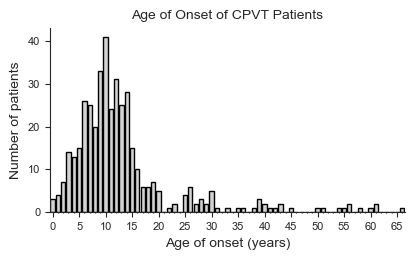

In [133]:
# FIGURE 2

fig2_panel_b = figure_2.panels["panel_b"]

plt.figure(figsize=fig2_panel_b.fig_size)

ax = plt.gca()

sns.barplot(
    data=df_age_onset_graph,
    x=AGE_OF_ONSET_COL,
    y="count",
    color=colors.default_hist,
    edgecolor="black",
    legend=False,
    ax=ax
)

x_tick_range = range(int(df_age_onset_graph[AGE_OF_ONSET_COL].max() + 1))
ax.set_xticks(x_tick_range)


def x_major_tick(x_val: int):
    return (x_val + 0) % 5 == 0


ax.set_xticklabels([
    x if x_major_tick(x) else "" for x in x_tick_range
])

# _, median_age_onset_global, _, _ = get_median_and_mean(
#     df_cpvt_unique_by_patient[
#         df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()])
# plt.axvline(
#     median_age_onset_global,
#     color='r',
#     linestyle='dashed',
#     linewidth=1,
#     label=f"Median: {median_age_onset_global:.2f}"
# )

for tick in ax.get_xticklines():
    if not x_major_tick(tick.get_xdata()[0]):
        tick.set_markersize(1)

sns.despine()

set_figure_size(fig2_panel_b)

plt.grid(False)
plt.tight_layout()

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"hist_age_of_onset.{fmt}"), format=fmt,
        dpi=300
    )

In [134]:
# calculate skewness and kurtosis
skewness = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].skew()
kurtosis = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].kurtosis()

skew_kurt_str = f"Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}"

skew_kurt_str

'Skewness: 2.43, Kurtosis: 6.85'

In [135]:
report["age_onset_global"] = PdfSection(
    section="Age of Onset Summary",
    stuff=[
        age_onset_info,
        skew_kurt_str
    ]
)

## Age of onset vs Exon

In [136]:
filtered_exon = \
    df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "exon_start"])[
        ["individual_id", "exon_start", "cdna_change_type",
         AGE_OF_ONSET_COL]].copy()
# only missense (at cdna level)
filtered_exon = filtered_exon[
    filtered_exon["cdna_change_type"] == "Substitution"]

filtered_exon["exon_start"] = filtered_exon["exon_start"].astype(int)

num_pat_per_exon = filtered_exon["exon_start"].value_counts().reset_index()
num_pat_per_exon.head()

,exon_start,count
0,90,54
1,14,47
2,8,34
3,47,21
4,105,16


In [137]:
MIN_NUM_INDIVIDUALS = 5

# fig, ax = plt.subplots(figsize=(15, 5))
filtered_exon_for_analysis = filtered_exon[
    filtered_exon["exon_start"].isin(
        num_pat_per_exon[num_pat_per_exon["count"] >= MIN_NUM_INDIVIDUALS][
            "exon_start"]
    )
]

filtered_exon_for_analysis.head()

,individual_id,exon_start,cdna_change_type,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1
3,4,99,Substitution,2.0
4,5,99,Substitution,10.0
5,6,99,Substitution,2.0
6,7,99,Substitution,10.0
18,19,47,Substitution,12.0


In [138]:
def get_stats_df(gb_df: pd.DataFrame, gb_column: str, sort_values="median"):
    stats_to_use = ['mean', 'median', lambda x: x.quantile(0.25),
                    lambda x: x.quantile(0.75), 'count']

    df_stats = gb_df.groupby(gb_column).agg({
        AGE_OF_ONSET_COL: stats_to_use,
    })

    df_stats.columns = ['mean', 'median', 'q1', 'q3', 'n']

    df_stats.reset_index(inplace=True)

    df_stats.sort_values(by=sort_values, ascending=True, inplace=True)

    return df_stats


exon_stats = get_stats_df(filtered_exon, 'exon_start')

exon_stats.sort_values(by="exon_start", inplace=True)

exon_stats.to_csv(figures_dir / "exon_stats.csv")

exon_stats.head()

,exon_start,mean,median,q1,q3,n
0,3,16.500000,16.5,14.75,18.25,2
1,6,12.000000,12.0,12.00,12.00,1
2,8,13.705882,11.5,7.25,16.75,34
3,13,14.000000,14.0,14.00,14.00,1
4,14,14.574468,12.0,9.50,16.50,47


In [139]:
# print how many exons have at least 5 patients

n_exons_test = f"Number of exons with at least {MIN_NUM_INDIVIDUALS} patients: {len(filtered_exon_for_analysis['exon_start'].unique())}"

n_exons_test

'Number of exons with at least 5 patients: 22'

In [140]:
import scipy.stats as stats

age_of_onset_by_exon = filtered_exon_for_analysis.groupby("exon_start")

# Perform the Kruskal-Wallis test
stat_exon, p_exon = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in age_of_onset_by_exon]
)

print(
    f"Kruskal-Wallis H-test: H={stat_exon:.2f}, P={p_exon:.2g}, dof={len(age_of_onset_by_exon) - 1}, n={len(filtered_exon)}")

Kruskal-Wallis H-test: H=72.56, P=1.4e-07, dof=21, n=358


In [141]:
import scikit_posthocs as sp

In [142]:
# age of onset vs EXON
pvals_exons = sp.posthoc_dunn(
    filtered_exon_for_analysis,
    val_col=AGE_OF_ONSET_COL,
    group_col="exon_start",
    p_adjust="bonferroni",
)
pvals_exons.to_csv(figures_dir / "exon_pvals.csv")
pvals_exons.head()

,8,14,15,37,43,44,45,46,47,49,...,89,90,93,94,97,99,100,101,102,105
8,1.0,1.0,1.0,1.0,1.0,1.0,0.115416,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.324659,1.0
14,1.0,1.0,1.0,1.0,1.0,1.0,0.012789,1.0,1.0,1.0,...,1.0,0.064931,1.0,1.0,1.0,1.0,1.0,1.0,0.042820,1.0
15,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0
37,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0
43,1.0,1.0,1.0,1.0,1.0,1.0,0.145307,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.336567,1.0


In [143]:
from itertools import combinations

sig_dunn_exons = []

for c1, c2 in combinations(pvals_exons.columns, 2):
    if pvals_exons.loc[c1, c2] < 0.05:
        sig_dunn_exons.append(
            f"{c1} vs {c2}: {pvals_exons.loc[c1, c2]:.6f}"
        )
        print(sig_dunn_exons[-1])

14 vs 45: 0.012789
14 vs 102: 0.042820
45 vs 89: 0.018472
45 vs 93: 0.003522
45 vs 94: 0.038511
89 vs 102: 0.045286
93 vs 102: 0.009990


In [144]:
report["exon"] = PdfSection(
    section="Age of Onset vs Exon",
    stuff=[
        n_exons_test,
        f"Kruskal-Wallis H-test: H={stat_exon:.2f}, P={p_exon:.2g}, n={len(filtered_exon)}",
        *sig_dunn_exons
    ]
)

In [145]:
import colorcet as cc

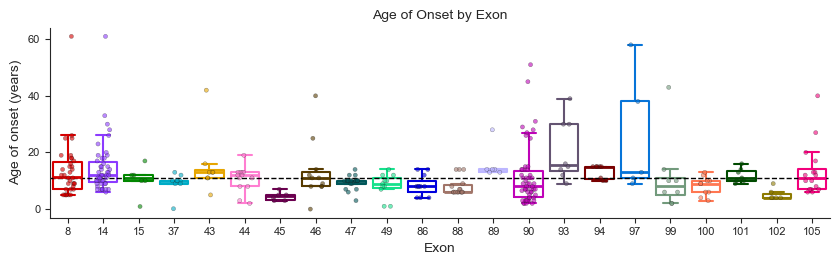

In [146]:
sns.set_style("ticks")

fig_4_c = figure_4.panels["panel_c"]

plt.figure(figsize=figure_4.fig_size)

palette_exon = cc.glasbey_dark[
               :len(filtered_exon_for_analysis["exon_start"].unique())]

ax = sns.boxplot(
    data=filtered_exon_for_analysis,
    y=AGE_OF_ONSET_COL,
    x="exon_start",
    # linewidth=1,
    fill=False,
    # width=0.8,
    palette=palette_exon,
    hue="exon_start",
    medianprops=colors.box_median_props,
    linecolor="black",
    color="white",
    #fill=False,
    showfliers=False,
    legend=False,
)

# add scatter plot
sns.stripplot(
    data=filtered_exon_for_analysis,
    y=AGE_OF_ONSET_COL,
    x="exon_start",
    color="black",
    alpha=0.6,
    linewidth=0.25,
    size=3,
    jitter=0.2,
    palette=palette_exon,
    hue="exon_start",
    legend=False,
)

# add a dotted line at global median
plt.axhline(
    df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median(),
    color='black',
    linestyle='dashed',
    linewidth=1,
    label=f"Median: {df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median():.2f}"
)
# # add dotted line for the graph median (they were basically the same)
# plt.axhline(
#     filtered_exon_for_analysis[AGE_OF_ONSET_COL].median(),
#     color=sns_orange,
#     linestyle='dashed',
#     linewidth=1,
#     label=f"Median: {filtered_exon_for_analysis[AGE_OF_ONSET_COL].median():.2f}"
# )

set_figure_size(
    fig_4_c,
)

sns.despine()

save_current_plot("age_of_onset_vs_exon")

plt.show()

## Age of onset vs Domain

In [147]:
filtered_domain = df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "domain"])[
    ["individual_id", AGE_OF_ONSET_COL, "domain", "protein_change_type"]
]
# only missense (at protein level)
filtered_domain = filtered_domain[
    filtered_domain["protein_change_type"] == "Substitution"]

num_pat_per_domain = filtered_domain["domain"].value_counts().reset_index()
num_pat_per_domain

,domain,count
0,NTD,97
1,BSol,92
2,CSol,74
3,TM,63
4,CTD,24
5,TaF,23
6,SPRY,10
7,JSol,9
8,SCLP,2


In [148]:
# domains
domains_df = pd.read_csv("./data_commit/ryr2_subdomains.csv")

In [149]:
# combine tables
domain_stats = get_stats_df(filtered_domain, 'domain')

#domain_stats.columns = ["mean", "median", "q1", "q3", "count"]
domain_stats["mean"] = domain_stats["mean"].round(2)

domain_stat_order = [
    v for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domain_stats["domain"])
]

print(domain_stat_order)

domain_stats.set_index("domain", inplace=True)
domain_stats = domain_stats.loc[domain_stat_order]

domain_stats.to_csv(figures_dir / "domain_stats.csv", index=True)

domain_stats

['NTD', 'SPRY', 'JSol', 'BSol', 'SCLP', 'CSol', 'TaF', 'TM', 'CTD']


,mean,median,q1,q3,n
domain,,,,,
NTD,14.07,12.0,9.00,16.00,97
SPRY,13.20,12.0,8.75,12.75,10
JSol,9.24,10.0,9.00,10.00,9
BSol,15.17,10.0,8.00,14.00,92
SCLP,36.00,36.0,26.50,45.50,2
CSol,10.78,8.0,6.00,14.00,74
TaF,13.13,11.0,6.00,14.50,23
TM,13.10,10.0,9.00,14.50,63
CTD,13.33,12.5,7.75,14.25,24


### Filter Domains for >5 patients

Kruskal Wallis usually run on groups with at least 5 obs

In [150]:
# fig, ax = plt.subplots(figsize=(15, 5))
filtered_domain_gt_5 = filtered_domain[
    filtered_domain["domain"].isin(
        num_pat_per_domain[num_pat_per_domain["count"] >= MIN_NUM_INDIVIDUALS][
            "domain"]
    )
]

domain_order_gt5 = [
    v
    for v in domains_df["domains"].dropna().str.strip().values
    if v in set(filtered_domain_gt_5["domain"])
]

domain_order_gt5

['NTD', 'SPRY', 'JSol', 'BSol', 'CSol', 'TaF', 'TM', 'CTD']

In [151]:
# Perform the Kruskal-Wallis test on domains with at least 5 patients
stat_domain, p_domain = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in
      filtered_domain_gt_5.groupby("domain")]
)

print(
    f"Kruskal-Wallis H-test: H={stat_domain:.2f}, P={p_domain:.2g}, n={len(filtered_domain_gt_5)}")

Kruskal-Wallis H-test: H=16.43, P=0.021, n=392


In [152]:
# age of onset vs EXON
pvals_domains = sp.posthoc_dunn(
    filtered_domain_gt_5,
    val_col=AGE_OF_ONSET_COL,
    group_col="domain",
    p_adjust="bonferroni",
)

pvals_domains.to_csv(figures_dir / "domain_pvals.csv")

pvals_domains

,BSol,CSol,CTD,JSol,NTD,SPRY,TM,TaF
BSol,1.000000,0.702982,1.00000,1.0,1.000000,1.0,1.0,1.0
CSol,0.702982,1.000000,0.80843,1.0,0.004691,1.0,1.0,1.0
CTD,1.000000,0.808430,1.00000,1.0,1.000000,1.0,1.0,1.0
JSol,1.000000,1.000000,1.00000,1.0,1.000000,1.0,1.0,1.0
NTD,1.000000,0.004691,1.00000,1.0,1.000000,1.0,1.0,1.0
SPRY,1.000000,1.000000,1.00000,1.0,1.000000,1.0,1.0,1.0
TM,1.000000,1.000000,1.00000,1.0,1.000000,1.0,1.0,1.0
TaF,1.000000,1.000000,1.00000,1.0,1.000000,1.0,1.0,1.0


In [153]:
from itertools import combinations

domain_dunn_sig = []

for c1, c2 in combinations(pvals_domains.columns, 2):
    if pvals_domains.loc[c1, c2] < 0.05:
        domain_dunn_sig.append(
            f"{c1} vs {c2}: {pvals_domains.loc[c1, c2]:.6f}"
        )
        print(domain_dunn_sig[-1])

CSol vs NTD: 0.004691


In [154]:
report["domain"] = PdfSection(
    section="Age of Onset vs Domain",
    stuff=[
        f"Kruskal-Wallis H-test: H={stat_domain:.2f}, P={p_domain:.2g}, n={len(filtered_domain_gt_5)}",
        *domain_dunn_sig
    ]
)

## Subdomains

In [155]:
filtered_sub_domain = \
    df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "subdomain"])[
        ["individual_id", AGE_OF_ONSET_COL, "domain", "subdomain",
         "protein_change_type"]
    ]

# only missense (at protein level)
filtered_sub_domain = filtered_sub_domain[
    filtered_sub_domain["protein_change_type"] == "Substitution"
    ]

num_pat_per_sub_domain = filtered_sub_domain[
    "subdomain"].value_counts().reset_index()
num_pat_per_sub_domain.head()

,subdomain,count
0,BSol1,90
1,CSol(exEF-hand),69
2,NSol,50
3,NTD-A,38
4,pVSD,33


In [156]:
# stats

sub_domain_stats = get_stats_df(filtered_sub_domain, 'subdomain').set_index(
    "subdomain")
sub_domain_stats["mean"] = sub_domain_stats["mean"].round(2)

sub_domain_stat_order = [
    v for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(sub_domain_stats.index)
]

print(sub_domain_stat_order)

sub_domain_stats = sub_domain_stats.loc[sub_domain_stat_order]

sub_domain_stats.to_csv(figures_dir / "sub_domain_stats.csv")

sub_domain_stats.head()

['NTD-A', 'NTD-B', 'NSol', 'SPRY1', 'SPRY2', 'SPRY3', 'RY1&2', 'JSol', 'BSol1', 'BSol2', 'RY3&4', 'SCLP', 'CSol(exEF-hand)', 'EF1&2', 'TaF', 'TM', 'Sx', 'pVSD', 'Pore', 'CTD', 'ZnF']


,mean,median,q1,q3,n
subdomain,,,,,
NTD-A,13.87,12.0,8.25,16.75,38
NTD-B,15.33,12.0,11.00,14.00,9
NSol,14.00,12.0,9.00,15.75,50
SPRY1,12.00,12.0,12.00,12.00,1
SPRY2,3.00,3.0,3.00,3.00,1


### Filter Subdomains for >5 patients

In [157]:
sub_domain_gt_5 = filtered_sub_domain[
    filtered_sub_domain["subdomain"].isin(
        num_pat_per_sub_domain[
            num_pat_per_sub_domain["count"] >= MIN_NUM_INDIVIDUALS][
            "subdomain"]
    )
]
sub_domain_gt_5.head()

,individual_id,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,domain,subdomain,protein_change_type
3,4,2.0,TM,pVSD,Substitution
4,5,10.0,TM,pVSD,Substitution
5,6,2.0,TM,pVSD,Substitution
6,7,10.0,TM,pVSD,Substitution
18,19,12.0,BSol,BSol1,Substitution


In [158]:
sub_domain_order_gt5 = [
    v
    for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(sub_domain_gt_5["subdomain"])
]

sub_domain_order_gt5

['NTD-A',
 'NTD-B',
 'NSol',
 'SPRY3',
 'JSol',
 'BSol1',
 'CSol(exEF-hand)',
 'EF1&2',
 'TaF',
 'pVSD',
 'Pore',
 'CTD']

In [159]:
# Perform the Kruskal-Wallis test on domains with at least 5 patients
stat_sub_domain, p_sub_domain = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in
      sub_domain_gt_5.groupby("subdomain")]
)

print(
    f"Kruskal-Wallis H-test: H={stat_sub_domain:.2f}, P={p_sub_domain:.2g}, n={len(sub_domain_gt_5)}")

Kruskal-Wallis H-test: H=28.95, P=0.0023, n=381


In [160]:
# age of onset vs EXON
pvals_sub_domains = sp.posthoc_dunn(
    sub_domain_gt_5,
    val_col=AGE_OF_ONSET_COL,
    group_col="subdomain",
    p_adjust="bonferroni",
)

pvals_sub_domains.to_csv(figures_dir / "sub_domain_pvals.csv")

pvals_sub_domains.head()

,BSol1,CSol(exEF-hand),CTD,EF1&2,JSol,NSol,NTD-A,NTD-B,Pore,SPRY3,TaF,pVSD
BSol1,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000
CSol(exEF-hand),1.0,1.0,1.0,1.0,1.0,0.034643,0.235828,0.323633,1.0,1.0,1.0,0.174822
CTD,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000
EF1&2,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000
JSol,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000


In [161]:
subdomain_dunn_sig = []

for c1, c2 in combinations(pvals_sub_domains.columns, 2):
    if pvals_sub_domains.loc[c1, c2] < 0.05:
        subdomain_dunn_sig.append(
            f"{c1} vs {c2}: {pvals_sub_domains.loc[c1, c2]:.6f}"
        )
        print(subdomain_dunn_sig[-1])

CSol(exEF-hand) vs NSol: 0.034643


In [162]:
report["sub_domain"] = PdfSection(
    section="Age of Onset vs Subdomain",
    stuff=[
        f"Kruskal-Wallis H-test: H={stat_sub_domain:.2f}, P={p_sub_domain:.2g}, n={len(sub_domain_gt_5)}",
        *subdomain_dunn_sig
    ]
)

## Save Report

In [163]:
from analysis.write_report import write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# report
pdf_name = figures_dir / "age_of_onset.pdf"

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, list(report.values()))
c.save()

print(f"PDF saved to {pdf_name}")

PDF saved to ../figures/0_3_2/analysis_06/age_of_onset.pdf


## Figures

In [164]:
figure_6.panels

{'panel_c': FigureParams(fig_size=None, title='Age of Onset by RYR2 Domain', xlabel='Domain', ylabel='Age of onset (years)', xticklabels=None, yticklabels=None, x_label_fontsize=10, y_label_fontsize=10, title_fontsize=10, x_tick_fontsize=8, y_tick_fontsize=8, panels=None),
 'panel_d': FigureParams(fig_size=None, title='Age of Onset by RYR2 Subdomain', xlabel='Subdomain', ylabel='Age of onset (years)', xticklabels=None, yticklabels=None, x_label_fontsize=10, y_label_fontsize=10, title_fontsize=10, x_tick_fontsize=8, y_tick_fontsize=8, panels=None)}

In [165]:
# use colors from chimerax
# https://color.adobe.com/RYR-domains-palette---for-bar-color-theme-1418b1f4-054c-4360-98ce-52705766067c/
# AA for white background
dark_color_palette = {
    # opt for display on white background
    "ntd": "#0E7490",
    "spry": "#C2410C",
    "jsol": "#B242B3",
    "bsol": "#713F12",
    "sclp": "#4D7C0F",
    "csol": "#1575BC",
    "taf": "#9F1239",
    "tm": "#4B5563",
    "ctd": "#064E3B"
}

# https://color.adobe.com/RYR-domains-palette---black-text-color-theme-d489fbc0-974a-4e0e-a776-dbf4c246cde9/
# for filled bars - opt for black on color
# AAA for dark text on color
light_color_palette = {
    "ntd": "#C7D2FE",
    "spry": "#FB923C",
    "jsol": "#A78BFA",
    "bsol": "#FEF08A",
    "sclp": "#A3E635",
    "csol": "#06B6D4",
    "taf": "#FB7185",
    "tm": "#CCCACC",
    "ctd": "#22C55E"
}


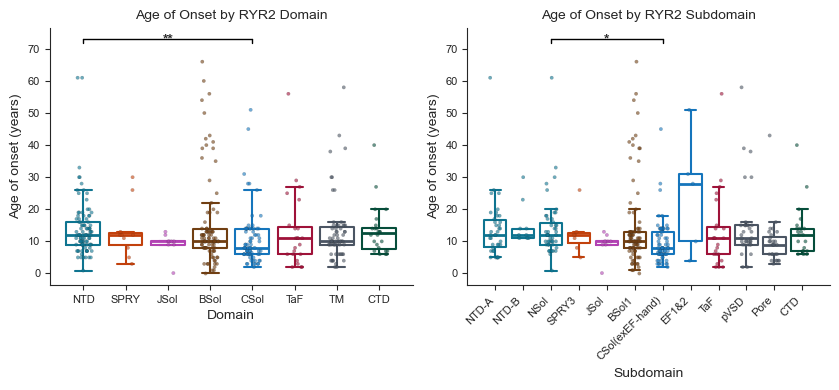

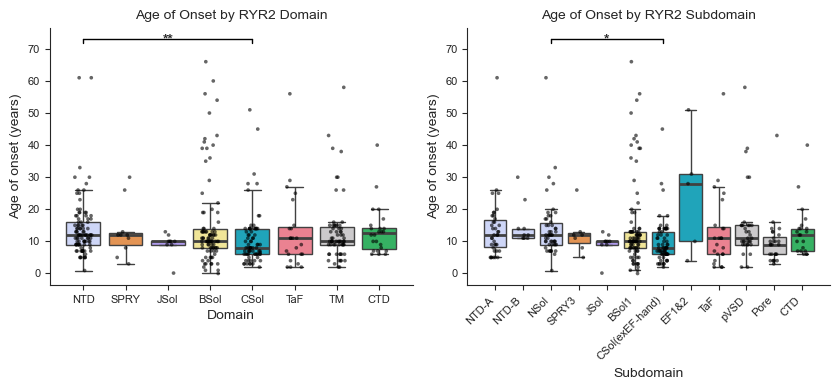

In [166]:
from matplotlib.gridspec import GridSpec


def convert_pvalue_to_asterisks(p_value: float):
    if p_value <= 0.0001:
        return "***"
    elif p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    return ""


def add_significance_lines(*,
                           p_value: float,
                           ax_curr: plt.Axes,
                           structure_order: list[str],
                           domain1: str,
                           domain2: str
                           ):
    p_str = convert_pvalue_to_asterisks(p_value)

    if p_str == "":
        return

    domain1_idx = structure_order.index(domain1)
    domain2_idx = structure_order.index(domain2)

    y_range = plt.ylim()[1] - plt.ylim()[0]

    y_pos = plt.ylim()[1] + (y_range) * 0.05

    ax_curr.plot(
        [domain1_idx, domain2_idx],
        [y_pos, y_pos],
        color="black",
        lw=1
    )
    ax_curr.plot(
        [domain1_idx, domain1_idx],
        [y_pos, y_pos - 1],
        color="black",
        lw=1
    )
    ax_curr.plot(
        [domain2_idx, domain2_idx],
        [y_pos, y_pos - 1],
        color="black",
        lw=1
    )

    ax_curr.text(
        (domain1_idx + domain2_idx) / 2,
        y_pos,
        p_str,
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold"
    )


def plot_boxplots(
        df_for_structure: pd.DataFrame,
        *,
        column: str,
        structure_pallette: dict[str, str],
        structure_order: list[str],
        ax_input: plt.Axes,
        panel_sel: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        p_vals_matrix: pd.DataFrame,
        box_fill: bool
):
    sns.boxplot(
        data=df_for_structure,
        y=AGE_OF_ONSET_COL,
        x=column,
        fill=box_fill,
        palette=structure_pallette,
        hue=column,
        medianprops={
            "linewidth": 2
        },
        legend=False,
        order=structure_order,
        showfliers=False,
        ax=ax_input
    )

    sns.stripplot(
        data=df_for_structure,
        y=AGE_OF_ONSET_COL,
        x=column,
        hue=column,
        hue_order=structure_order,
        order=structure_order,
        palette=['black'] * len(
            structure_order) if box_fill else structure_pallette,
        linewidth=0.1,
        alpha=0.6,
        size=2.5,
        jitter=0.2,
        ax=ax_input
    )

    for domain1, domain2 in combinations(structure_order, 2):
        if p_vals_matrix.loc[domain1, domain2] < 0.05:
            add_significance_lines(
                p_value=p_vals_matrix.loc[domain1, domain2],
                ax_curr=ax_input,
                structure_order=structure_order,
                domain1=domain1,
                domain2=domain2
            )

    set_figure_size(
        figure_6.panels[panel_sel],
        x_tick_rotation=x_tick_rotation,
        x_tick_ha=x_tick_ha
    )


sns.set_style("ticks")


def create_fig_6(
        all_domain_colors: dict[str, str],
        box_fill: bool = False
):
    # color pallete for plotting
    domain_color_pal = {
        domain: all_domain_colors[domain.lower()]
        for domain in domain_order_gt5
    }

    subdomain_color_pal = {
        row["subdomain"]: all_domain_colors[
            row["domain"].lower().strip()
        ]
        for _, row in sub_domain_gt_5.iterrows()
    }

    fig = plt.figure(figsize=figure_6.fig_size)
    gs = GridSpec(1, 2, figure=fig)

    # First plot
    ax1 = fig.add_subplot(gs[0, 0])
    plot_boxplots(
        filtered_domain_gt_5,
        column="domain",
        structure_pallette=domain_color_pal,
        structure_order=domain_order_gt5,
        ax_input=ax1,
        panel_sel="panel_c",
        p_vals_matrix=pvals_domains,
        box_fill=box_fill
    )
    ax2 = fig.add_subplot(gs[0, 1])
    plot_boxplots(
        sub_domain_gt_5,
        column="subdomain",
        structure_pallette=subdomain_color_pal,
        structure_order=sub_domain_order_gt5,
        ax_input=ax2,
        panel_sel="panel_d",
        x_tick_rotation=45,
        x_tick_ha="right",
        p_vals_matrix=pvals_sub_domains,
        box_fill=box_fill
    )

    fig.tight_layout()

    save_current_plot(
        f"age_of_onset_vs_domain_subdomain{'-filled' if box_fill else ''}")

    plt.show()

    plt.close()


create_fig_6(dark_color_palette, box_fill=False)
create_fig_6(light_color_palette, box_fill=True)